# Import Dependencies

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import os

# Set Paths 

In [2]:
INTERSECTION_PATH = "S:/selfdrivingcar/data/intersection"
LANE_PATH = "S:/selfdrivingcar/data/lane"

# Change these variables to where your data is stored from
# running the tensorflow_data_collection.py file. 


# Create Datasets and Standardize Image Size

In [3]:
!tree "S:/selfdrivingcar/data"

Folder PATH listing for volume extraspace
Volume serial number is F2EB-51BD
S:\SELFDRIVINGCAR\DATA
+---intersection
+---lane


# Create and Standardize Image Datasets

In [4]:
'''
1. Sets constant dimensions and batch size for images. 
2. Passed directory that containes DESIRED LABELS as sub-folders; see example above
3. Use the image_dataset_from_directory function from TensorFlow to partition data. We use 
   an 80/20 split and change the image size to the predefined values given.
'''

batch_size = 32
img_height = 180
img_width = 180

data_dir = "S:/selfdrivingcar/data"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 17735 files belonging to 2 classes.
Using 14188 files for training.
Found 17735 files belonging to 2 classes.
Using 3547 files for validation.


In [5]:
#Print class names
class_names = train_ds.class_names
print(class_names)


['intersection', 'lane']


In [6]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

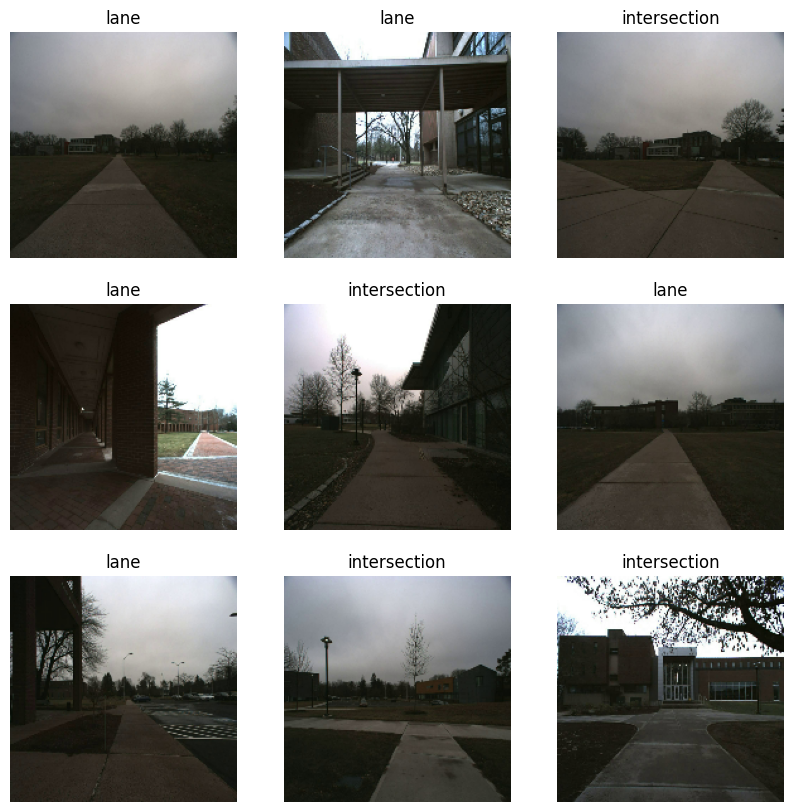

In [7]:
#Plot some example images and respective labels
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Dataset Configuration (for performance)

In [8]:
#Utilizes buffered prefetching to prevent I/O blocks
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
#Standardizing Data (converting RBG channels that range from [0, 255] to [0, 1]) through a lambda function
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Create CNN Model

In [15]:
num_classes = len(class_names) #2 classes

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(128, 3, padding='same', activation='relu', use_bias = True, kernel_regularizer =tf.keras.regularizers.l2(l=0.01)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l2(l=0.01)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l2(l=0.01)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(16, activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l1(l=0.01)),
  layers.Dense(num_classes, name="outputs")
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 32)       

In [18]:
for layer in model.layers:
    if hasattr(layer,'kernel_size'):
#         layer.name
        print(str(layer.name) + ":" + str(layer.kernel_size))

conv2d_3:(3, 3)
conv2d_4:(3, 3)
conv2d_5:(3, 3)


# Train Model

In [19]:
epochs=5 #Good number for loss to reach a global minimum
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/5
444/444 [==============================] - 339s 763ms/step - loss: 1.5354 - accuracy: 0.7210 - val_loss: 0.9087 - val_accuracy: 0.7192
Epoch 2/5
444/444 [==============================] - 334s 753ms/step - loss: 0.8898 - accuracy: 0.7213 - val_loss: 0.9238 - val_accuracy: 0.7192
Epoch 3/5
444/444 [==============================] - 331s 745ms/step - loss: 0.8752 - accuracy: 0.7313 - val_loss: 0.8910 - val_accuracy: 0.7939
Epoch 4/5
444/444 [==============================] - 329s 741ms/step - loss: 0.8671 - accuracy: 0.7702 - val_loss: 0.9004 - val_accuracy: 0.7953
Epoch 5/5
444/444 [==============================] - 324s 730ms/step - loss: 0.8552 - accuracy: 0.7766 - val_loss: 0.8003 - val_accuracy: 0.8131


# Visualize Results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Save Model for Inference (optional)

In [54]:
# MODEL_PATH = "S:/selfdrivingcar/model/ART_Robot.h5"
# model.save(MODEL_PATH)

# Load Trained Model and Predict

In [16]:
#Prevents the need to retrain a fresh model with every Python kernel refresh. 
model = tf.keras.models.load_model("S:/selfdrivingcar/model/ART_Robot.h5")

In [17]:
def predict_image(image):
    '''
    Predicts if there is an intersection ahead. Requires a PIL Image as input
    '''
    img_width = 180
    img_height = 180
    dim = (img_width, img_height)
    
    image = image.resize(dim)
    img_array = tf.keras.utils.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    return score

In [23]:
dim = (img_height, img_width)
cap = cv2.VideoCapture("S:/selfdrivingcar/videos/output.ogv") #Opens video using OpenCV

while cap.isOpened():
    ret, frame = cap.read()
    
    cv2.imshow('Frame',frame)
    
    snap = Image.fromarray(frame.astype('uint8'), 'RGB')
    prediction, score = predict_image(snap)
    confidence = 100*np.max(score)
    if (confidence <= 25):
        print(0) #Lane prediction
    else:
        print(1) #Intersection prediction
#     print(class_names[np.argmax(score)] + "-" + str(100*np.max(score)))
    
    print(confidence)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step
0
0.1976165222004056
1/1 [==============================] - 0s 20ms/step
0
0.19599352963268757
1/1 [==============================] - 0s 22ms/step
0
0.19708764739334583
1/1 [==============================] - 0s 21ms/step
0
0.19950848072767258
1/1 [==============================] - 0s 23ms/step
0
0.19893348217010498
1/1 [==============================] - 0s 24ms/step
0
0.19904589280486107
1/1 [==============================] - 0s 23ms/step
0
0.19608803559094667
1/1 [==============================] - 0s 21ms/step
0
0.1950511010363698
1/1 [==============================] - 0s 22ms/step
0
0.19226274453103542
1/1 [==============================] - 0s 22ms/step
0
0.19479850307106972
1/1 [==============================] - 0s 21ms/step
0
0.19369380315765738
1/1 [==============================] - 0s 21ms/step
0
0.1957480562850833
1/1 [==============================] - 0s 22ms/step
0
0.19619835074990988
1/1 [==============================] - 0s

1/1 [==============================] - 0s 19ms/step
1
48.29745888710022
1/1 [==============================] - 0s 18ms/step
1
44.12455856800079
1/1 [==============================] - 0s 18ms/step
0
10.59902086853981
1/1 [==============================] - 0s 18ms/step
1
60.972291231155396
1/1 [==============================] - 0s 17ms/step
0
5.522317439317703
1/1 [==============================] - 0s 18ms/step
0
0.055566924856975675
1/1 [==============================] - 0s 17ms/step
0
0.045716360909864306
1/1 [==============================] - 0s 17ms/step
0
4.496341198682785
1/1 [==============================] - 0s 17ms/step
0
12.315686047077179
1/1 [==============================] - 0s 18ms/step
0
4.683131352066994
1/1 [==============================] - 0s 17ms/step
0
0.18477760022506118
1/1 [==============================] - 0s 20ms/step
0
0.06471543456427753
1/1 [==============================] - 0s 19ms/step
0
0.16512090805917978
1/1 [==============================] - 0s 17ms/ste

1/1 [==============================] - 0s 17ms/step
0
0.2060978440567851
1/1 [==============================] - 0s 18ms/step
0
0.207783211953938
1/1 [==============================] - 0s 17ms/step
0
0.21787011064589024
1/1 [==============================] - 0s 17ms/step
0
0.14821435324847698
1/1 [==============================] - 0s 17ms/step
0
0.1205280190333724
1/1 [==============================] - 0s 18ms/step
0
0.15657590702176094
1/1 [==============================] - 0s 18ms/step
0
0.11754501610994339
1/1 [==============================] - 0s 19ms/step
0
0.1837590942159295
1/1 [==============================] - 0s 19ms/step
0
0.15192216960713267
1/1 [==============================] - 0s 19ms/step
0
0.15496830455958843
1/1 [==============================] - 0s 19ms/step
0
0.14380936045199633
1/1 [==============================] - 0s 18ms/step
0
0.1973903737962246
1/1 [==============================] - 0s 18ms/step
0
0.22746885661035776
1/1 [==============================] - 0s 18

1/1 [==============================] - 0s 16ms/step
1
99.99947547912598
1/1 [==============================] - 0s 17ms/step
1
99.99955892562866
1/1 [==============================] - 0s 19ms/step
1
99.99854564666748
1/1 [==============================] - 0s 16ms/step
1
99.9809205532074
1/1 [==============================] - 0s 18ms/step
1
99.97995495796204
1/1 [==============================] - 0s 16ms/step
1
99.94839429855347
1/1 [==============================] - 0s 17ms/step
1
99.97115731239319
1/1 [==============================] - 0s 18ms/step
1
99.98371601104736
1/1 [==============================] - 0s 17ms/step
1
99.99269247055054
1/1 [==============================] - 0s 18ms/step
1
99.98807907104492
1/1 [==============================] - 0s 17ms/step
1
99.96376037597656
1/1 [==============================] - 0s 17ms/step
1
99.93896484375
1/1 [==============================] - 0s 17ms/step
1
99.94530081748962
1/1 [==============================] - 0s 16ms/step
1
99.90150928497

1/1 [==============================] - 0s 20ms/step
1
99.99979734420776
1/1 [==============================] - 0s 18ms/step
1
99.98970031738281
1/1 [==============================] - 0s 19ms/step
1
99.96753931045532
1/1 [==============================] - 0s 19ms/step
1
99.90832805633545
1/1 [==============================] - 0s 17ms/step
1
99.97666478157043
1/1 [==============================] - 0s 17ms/step
1
99.96974468231201
1/1 [==============================] - 0s 18ms/step
1
99.9678373336792
1/1 [==============================] - 0s 18ms/step
1
99.88158941268921
1/1 [==============================] - 0s 17ms/step
1
99.81493949890137
1/1 [==============================] - 0s 17ms/step
1
99.44074153900146
1/1 [==============================] - 0s 18ms/step
1
99.96391534805298
1/1 [==============================] - 0s 18ms/step
1
90.95653295516968
1/1 [==============================] - 0s 17ms/step
1
92.79626607894897
1/1 [==============================] - 0s 17ms/step
1
27.40239500

1/1 [==============================] - 0s 17ms/step
0
3.275502100586891
1/1 [==============================] - 0s 18ms/step
0
4.757687449455261
1/1 [==============================] - 0s 18ms/step
0
5.755456164479256
1/1 [==============================] - 0s 17ms/step
0
1.785915531218052
1/1 [==============================] - 0s 16ms/step
0
1.4028067700564861
1/1 [==============================] - 0s 17ms/step
0
2.136141061782837
1/1 [==============================] - 0s 16ms/step
0
1.634277030825615
1/1 [==============================] - 0s 18ms/step
0
1.462146732956171
1/1 [==============================] - 0s 18ms/step
0
1.008667703717947
1/1 [==============================] - 0s 17ms/step
0
0.6660126615315676
1/1 [==============================] - 0s 16ms/step
0
0.4544555675238371
1/1 [==============================] - 0s 21ms/step
0
0.6974028889089823
1/1 [==============================] - 0s 19ms/step
0
0.5881419871002436
1/1 [==============================] - 0s 18ms/step
0
0.484

1/1 [==============================] - 0s 16ms/step
1
99.14743900299072
1/1 [==============================] - 0s 18ms/step
1
99.26232099533081
1/1 [==============================] - 0s 19ms/step
1
99.58593249320984
1/1 [==============================] - 0s 17ms/step
1
99.59858059883118
1/1 [==============================] - 0s 17ms/step
1
97.865891456604
1/1 [==============================] - 0s 16ms/step
1
99.26413893699646
1/1 [==============================] - 0s 18ms/step
1
99.10110235214233
1/1 [==============================] - 0s 19ms/step
1
99.37080144882202
1/1 [==============================] - 0s 15ms/step
1
99.21402335166931
1/1 [==============================] - 0s 19ms/step
1
99.46228265762329
1/1 [==============================] - 0s 20ms/step
1
98.08696508407593
1/1 [==============================] - 0s 17ms/step
1
94.5781946182251
1/1 [==============================] - 0s 17ms/step
1
91.55973792076111
1/1 [==============================] - 0s 17ms/step
1
89.6020531654

1
99.99961853027344
1/1 [==============================] - 0s 17ms/step
1
99.99938011169434
1/1 [==============================] - 0s 18ms/step
1
99.99932050704956
1/1 [==============================] - 0s 18ms/step
1
99.99929666519165
1/1 [==============================] - 0s 19ms/step
1
99.99849796295166
1/1 [==============================] - 0s 19ms/step
1
99.99785423278809
1/1 [==============================] - 0s 18ms/step
1
99.99984502792358
1/1 [==============================] - 0s 21ms/step
1
99.99990463256836
1/1 [==============================] - 0s 18ms/step
1
99.99983310699463
1/1 [==============================] - 0s 21ms/step
1
99.99977350234985
1/1 [==============================] - 0s 19ms/step
1
99.99991655349731
1/1 [==============================] - 0s 20ms/step
1
99.9998688697815
1/1 [==============================] - 0s 17ms/step
1
99.99982118606567
1/1 [==============================] - 0s 17ms/step
1
99.9998927116394
1/1 [==============================] - 0s 18ms